#Problème:

#Deux cas d'utilisation des données d'opportunité

La qualité de la description d'un phénomène physique dépend des moyens d'observation disponibles. Généralement, les moyens à disposition dépendent de la zone géographique et de la période considérée.
Lorsque les capteurs sont peu nombreux, on peut chercher à compléter l'observation par des données supplémentaires issues de capteurs non spécifiques. On parle alors de *données d'opportunité*.

Les *données d'opportunité* peuvent être exploitées par apprentissage. Une approche courante consiste à entraîner un modèle sur la zone où des capteurs spécifiques peuvent fournir une cible de qualité. Le modèle est ensuite porté là où seules les *données d'opportunité* sont disponibles.

Aujourd'hui, on utilise par exemple des données issues des réseaux de télécommunication pour préciser la localisation et l'intensité de phénomènes physiques ou sociaux.  
La première partie du problème est inspirée du cas où la donnée opportune est une atténuation du signal échangé entre les antennes d'un réseau mobile.

On cherche aussi à exploiter des données issues de capteurs de mauvaise qualité qui peuvent être beaucoup plus nombreux que les capteurs spécifiques. C'est ce qu'illustre la seconde partie.

**Note**: les deux parties du problème sont complètement indépendantes.

**Partie I - problème n°1 : régression avec un UNet**

In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Lien valable jusqu'au 17/01/2024:
# module à charger
! wget https://www.grosfichiers.com/HAnmgiuVNGn_XtdcYCeMNnJ
! mv HAnmgiuVNGn_XtdcYCeMNnJ utile_BE.py
! mkdir data
from utile_BE import *

--2024-01-05 16:21:20--  https://www.grosfichiers.com/HAnmgiuVNGn_XtdcYCeMNnJ
Resolving www.grosfichiers.com (www.grosfichiers.com)... 51.68.254.173
Connecting to www.grosfichiers.com (www.grosfichiers.com)|51.68.254.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27402 (27K) [application/octet-stream]
Saving to: ‘HAnmgiuVNGn_XtdcYCeMNnJ’

HAnmgiuVNGn_XtdcYCe 100%[===================>]  26.76K  --.-KB/s    in 0s      

2024-01-05 16:21:20 (291 MB/s) - ‘HAnmgiuVNGn_XtdcYCeMNnJ’ saved [27402/27402]



Dans ce problème, la cible $T$ est un champ physique scalaire, positif ou nul. On suppose que, dans le meilleur des cas, deux types de capteurs spécifiques sont disponibles.\
Le premier type fournit une mesure spatialisée du champ. Il n'est pas partout disponible. Le second type de capteur fournit une mesure ponctuelle. Ces capteurs sont implantés sur toute la zone d'intérêt mais il ne couvrent correctement que 0.5% de la surface.\
En plus de ces capteurs, on suppose qu'on a accès à des données issues d'un réseau de télécommunications. Ces données réflètent l'atténuation d'un signal échangé entre des antennes relais. On suppose que pour chaque signal émis entre deux antennes $A_i$, $A_j$, on peut calculer une quantité $S(A_i,A_j;T)$ qui ne dépend que de la valeur moyenne du champ $T$ sur le trajet entre $A_i$ et $A_j$.

On se place dans le cas où un jeu est constitué sur la zone où la mesure spatialisée du champ est disponible. Pour une première preuve de concept, on travaille avec des images de synthèse sur lesquelles:
- les mesures ponctuelles ont été attribuées aux pixels qui leur correspondent.
- les données d'opportunité sont représentées par des segments. Les extrémités d'un segment représentent deux antennes $A_i$, $A_j$. Le long d'un segment, l'intensité des pixels est constante, de valeur $S(A_i,A_j;T)$ (seule exception, dans le cas d'intersections, les valeurs sont simplement sommées - voir ci-dessous).

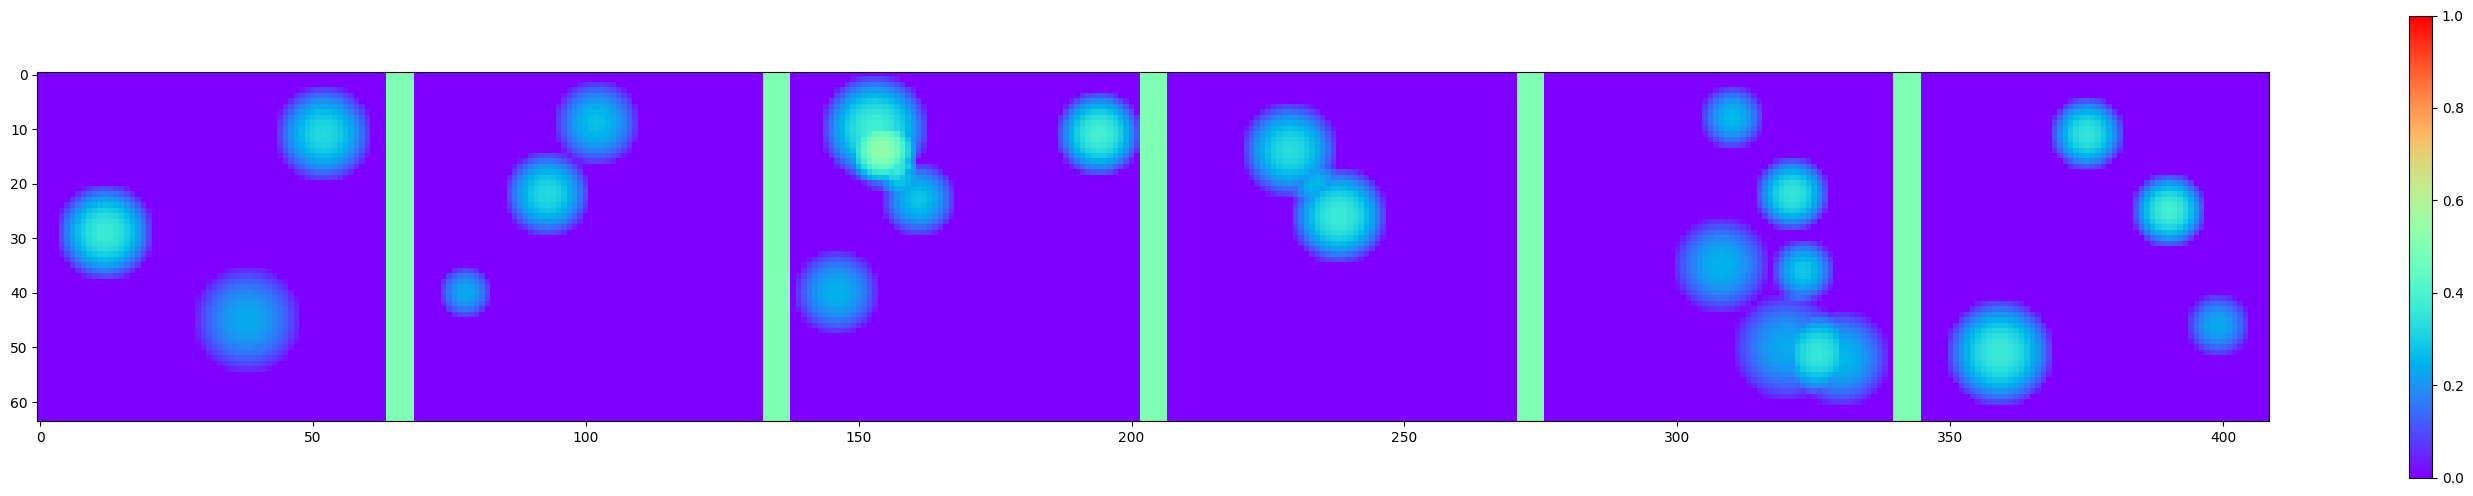

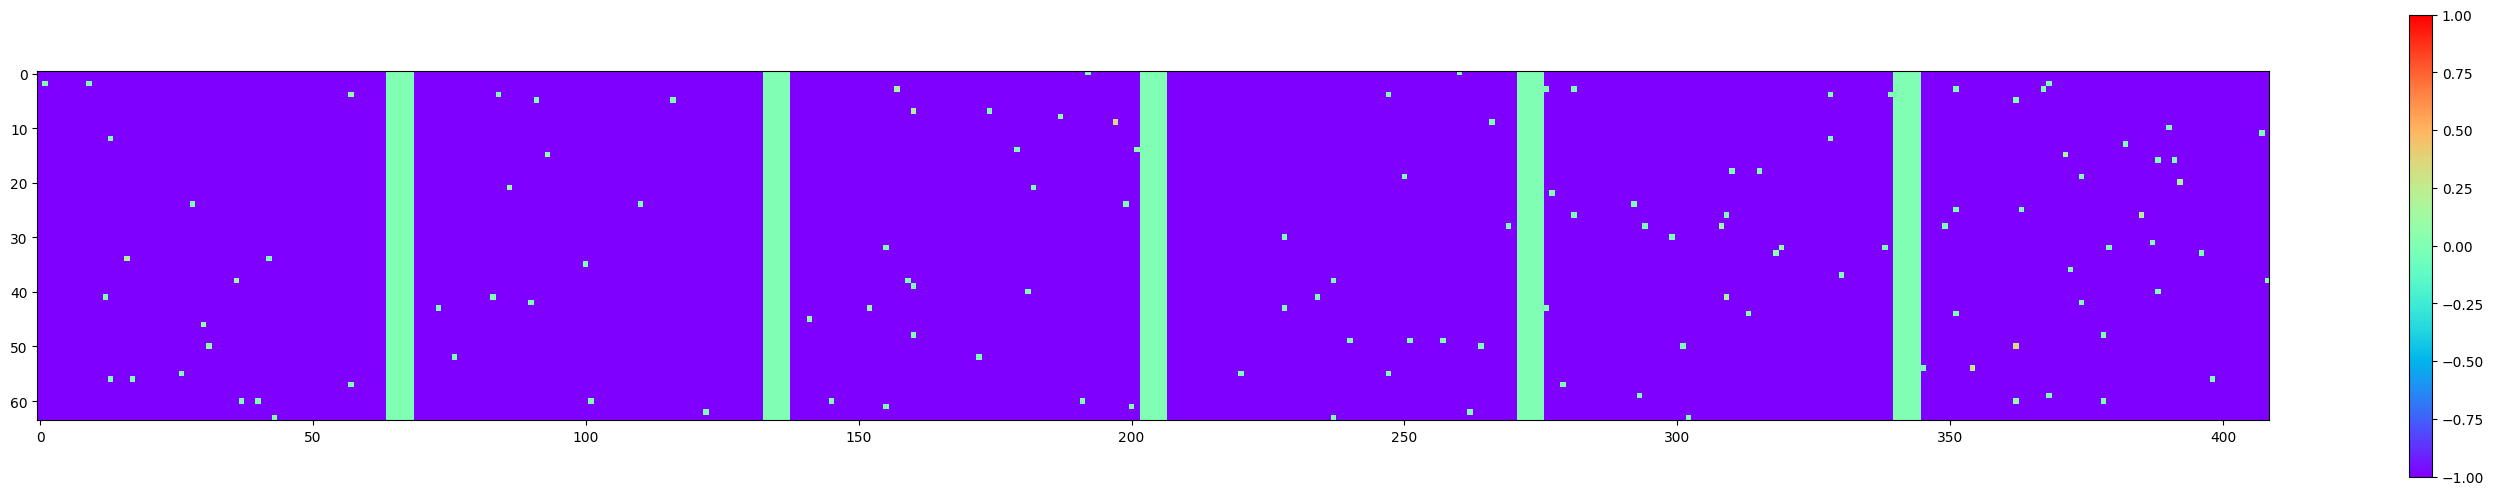

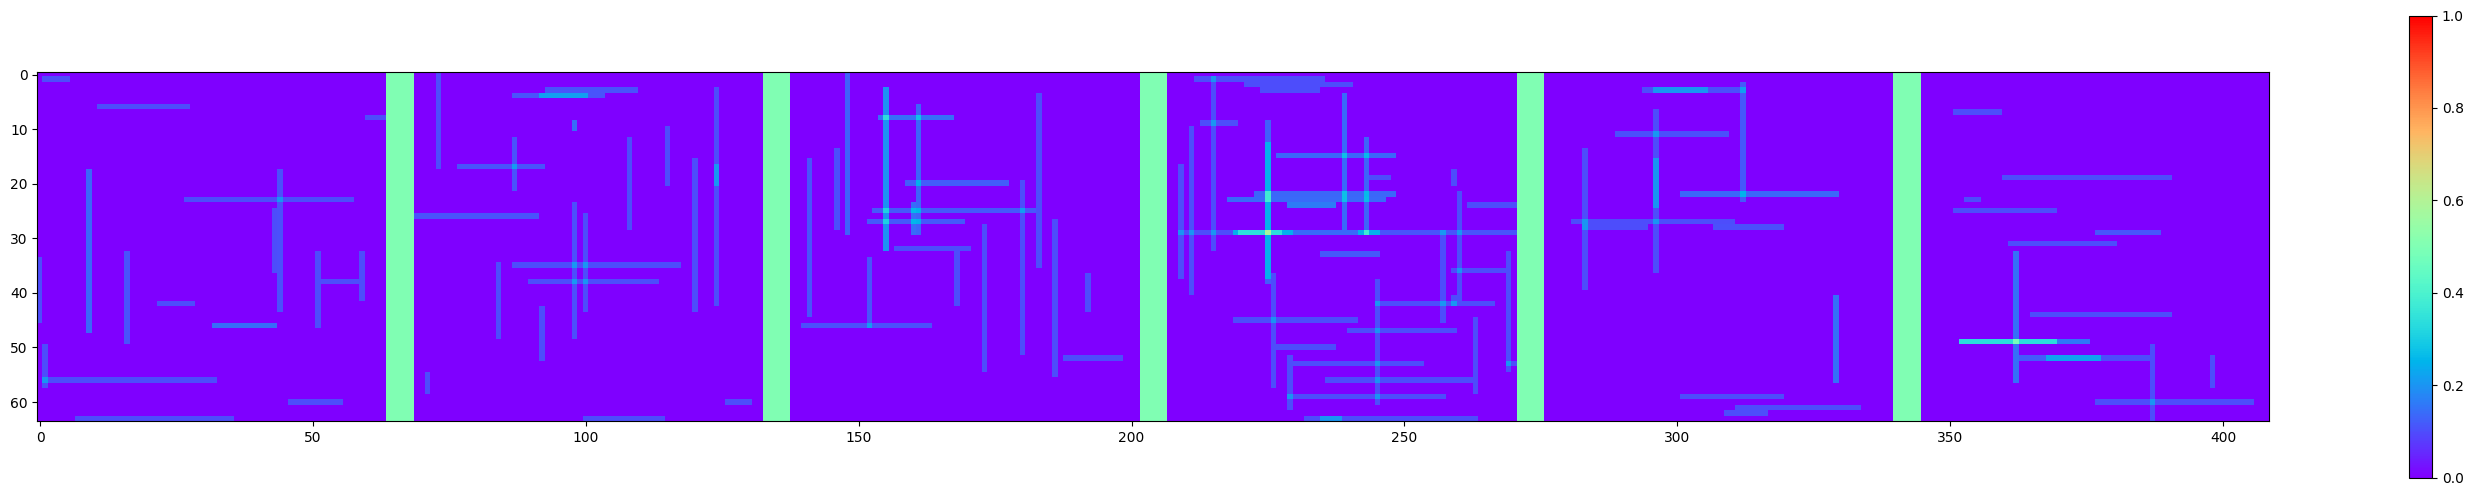

In [3]:
batch_size = 6
p = 0.5 / 100
full_target, partial_target, integrated_signals  = gen_image_with_integrated_signals(batch_size, p)


fig1 = plt.figure(1, figsize=(36, 6))
# champ T
voir_batch2D(full_target, 6, fig1, k=0, min_scale=0, max_scale=1)

# mesures ponctuelles
fig2 = plt.figure(2, figsize=(36, 6))
voir_batch2D(partial_target, 6, fig2, k=0, min_scale=-1, max_scale=1)

# représentation des données d'opportunité par des segments
fig3 = plt.figure(3, figsize=(36, 6))
voir_batch2D(integrated_signals, 6, fig3, k=0, min_scale=0, max_scale=1)

Dans la cellule précédente, la fonction *gen_image_with_integrated_signals* permet de visualiser le jeu simulé:
- *full_target* représente le champ $T$ vu par le premier type de capteur spécifique sur la zone couverte par l'image. Il s'agit de disques de valeurs positives.
- *partial_target* représente les mesures ponctuelles. En dehors des points de mesure, la valeur est fixée à -1.
- *integrated_signals* contient la représentation par segments. En dehors des segments, la valeur est fixée à 0. Dans cette simulation simpliste, les segments ont tous été supposés parallèles à l'un des deux côtés de l'image. De plus, $S$ a été modélisé comme une fonction affine, croissante de la valeur moyenne sur le segment. Ainsi, l'intensité d'un segment croit avec le nombre de disques traversés.

Dans cette partie, le but est de dire:\
**A.** si l'on peut entraîner avec succès un *FCN* à restituer $T$ **à partir** de données d'opportunité représentées par des segments (**exercice 1**).\
**B.** si en combinant des données d'opportunité aux mesures ponctuelles, on améliore bien les performances d'un $FCN$ (**exercice 2**).

**Exercice 1**

**Q1** Dans la cellule suivante, instancier un UNet. Choisir correctement *ch_in* et *ch_out*.

In [4]:
ch_in = 1
ch_out = 1
size = 8

fcn = UNet(ch_in, ch_out, size).cuda()

**Q2** Combien de poids ce réseau contient-il ? Ecrire le calcul ou intégrer un bout de code qui conduit au résultat.

In [5]:
print(fcn)

UNet(
  (inc): inconv(
    (conv): double_conv(
      (conv): Sequential(
        (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
  (down1): Down(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): double_conv(
        (conv): Sequential(
          (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(16, eps=

In [6]:
nb_weights = 0
for module in fcn.modules():
  if isinstance(module, nn.Conv2d) or isinstance(module, nn.BatchNorm2d) or isinstance(module, nn.ConvTranspose2d):
    for parameter in module.parameters():
      nb_weights += torch.numel(parameter)

print(nb_weights)

232546


**Q3** Présenter brièvement les types de couches utilisées dans ce réseau.

Conv2d : couche de convolutions (utilisée particulièrement pour l'apprentissage profond), applique un noyau sur l'entrée donnant pour résultat un tenseur susceptible d'être sujet à un autre noyau.

MaxPool2d : sélectionne la valeur maximale selon taille du tenseur proposé, sans options supplémentaires la taille de la sortie est inférieure à celle de l'entrée

ReLU : Prends la partie positive de chaque entrée donc devient nulle si négative

BatchNorm2d : normalise l'entrée suivant la moyenne et l'écart-type du batch

ConvTranspose2d : S'effectue de la même façon que Conv2d mais avec un certain padding initial

**Q4** Dans la cellule suivante, coder en une ligne l'erreur absolue moyenne (MAE).

In [7]:
def criterion(output,target):
  return torch.mean(torch.abs(output - target))

**Q5** Instancier l'optimizer Adam avec un taux d'apprentissage de 0.0002.

In [8]:
optimizer = optim.Adam(fcn.parameters(), lr = 0.0002)

**Q6** Pourquoi est-il, en général, nécessaire de passer par une étape de validation lors d'un apprentissage ? Pourquoi peut-on s'en passer dans le cas où les images sont générées la volée ?

L'étape de validation permet en quelque sorte de valider l'apprentissage, en testant le modèle entraîné sur un ensemble de données non utilisées jusqu'à maintenant. Cela permet entre autres vérifier s'il n'y de surapprentissage et de s'assurer que le modèle répond bien (justesse élevée) sur un ensemble d'entrées diverses.

On peut s'en passer car on dispose ainsi d'un ensemble de données pour l'apprentissage d'une taille supposée infinie ce qui efface les problèmes que tente de résoudre l'étape de validation.

**Q7** Ecrire la boucle d'apprentissage. On stockera la MAE à chaque époque.
- nombre d'époque : 30
- batches par époque : 100
- taille de batch : 32

In [9]:
nepochs = 30
nbatches = 100
batchsize = 32

train_losses = []


for epoch in range(nepochs):


    print("Epoch " + str(epoch))
    epoch_losses  = []
    for i in range(nbatches):    # nbatch = datasetsize/batchsize
        #Load inputs

        optimizer.zero_grad()

        target, _, input = gen_image_with_integrated_signals(batch_size, p)

        target = target.cuda()
        input = input.cuda()

        output = fcn(input)

        loss = criterion(output, target)

        epoch_losses.append(loss.detach().cpu())

        loss.backward()

        optimizer.step()

        del target, input, loss
        torch.cuda.empty_cache()

    epoch_loss = np.mean(epoch_losses)
    train_losses.append(epoch_loss)

    print('epoch loss : \n')
    print(epoch_loss)

Epoch 0
epoch loss : 

0.14924552
Epoch 1
epoch loss : 

0.07200685
Epoch 2
epoch loss : 

0.05902725
Epoch 3
epoch loss : 

0.052056674
Epoch 4
epoch loss : 

0.050628576
Epoch 5
epoch loss : 

0.04757587
Epoch 6
epoch loss : 

0.04579038
Epoch 7
epoch loss : 

0.044988558
Epoch 8
epoch loss : 

0.04366548
Epoch 9
epoch loss : 

0.042993683
Epoch 10
epoch loss : 

0.041991968
Epoch 11
epoch loss : 

0.041293293
Epoch 12
epoch loss : 

0.041396044
Epoch 13
epoch loss : 

0.04087118
Epoch 14
epoch loss : 

0.039783344
Epoch 15
epoch loss : 

0.040375695
Epoch 16
epoch loss : 

0.038836036
Epoch 17
epoch loss : 

0.03963131
Epoch 18
epoch loss : 

0.03823094
Epoch 19
epoch loss : 

0.03728911
Epoch 20
epoch loss : 

0.0372195
Epoch 21
epoch loss : 

0.037698314
Epoch 22
epoch loss : 

0.036670033
Epoch 23
epoch loss : 

0.03694171
Epoch 24
epoch loss : 

0.03592273
Epoch 25
epoch loss : 

0.035769798
Epoch 26
epoch loss : 

0.037551798
Epoch 27
epoch loss : 

0.03593187
Epoch 28
epoch lo

**Q8** Visualisez les résultats. Quelle conséquence visible le choix de la fonction de coût a-t-il eu ? Conclure sur le point **A.**

Text(0.5, 1.0, 'train losses')

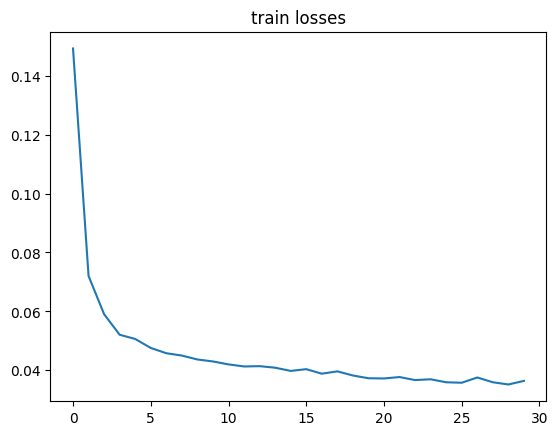

In [15]:
plt.plot(train_losses)
plt.title('train losses')

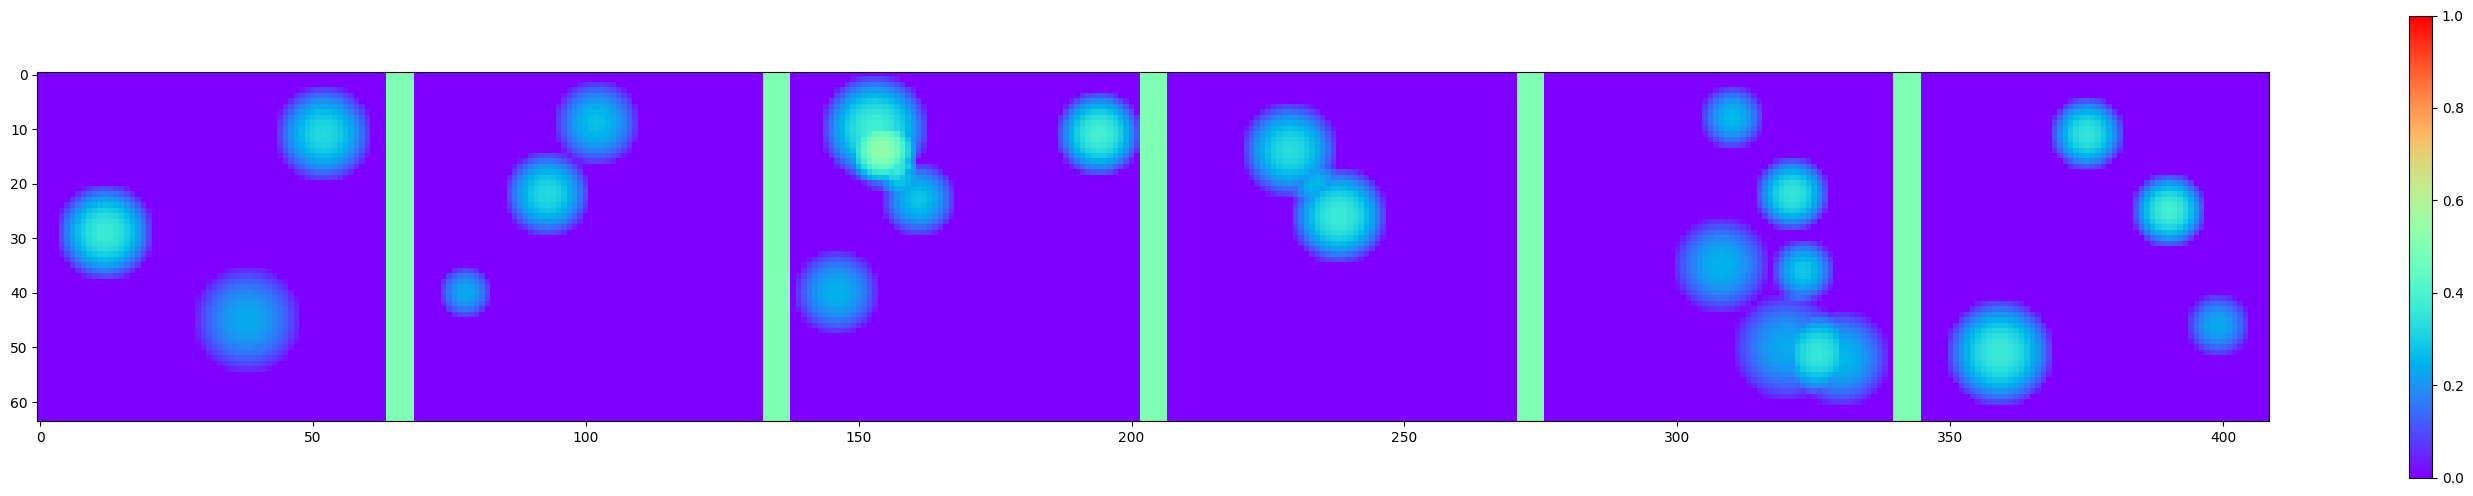

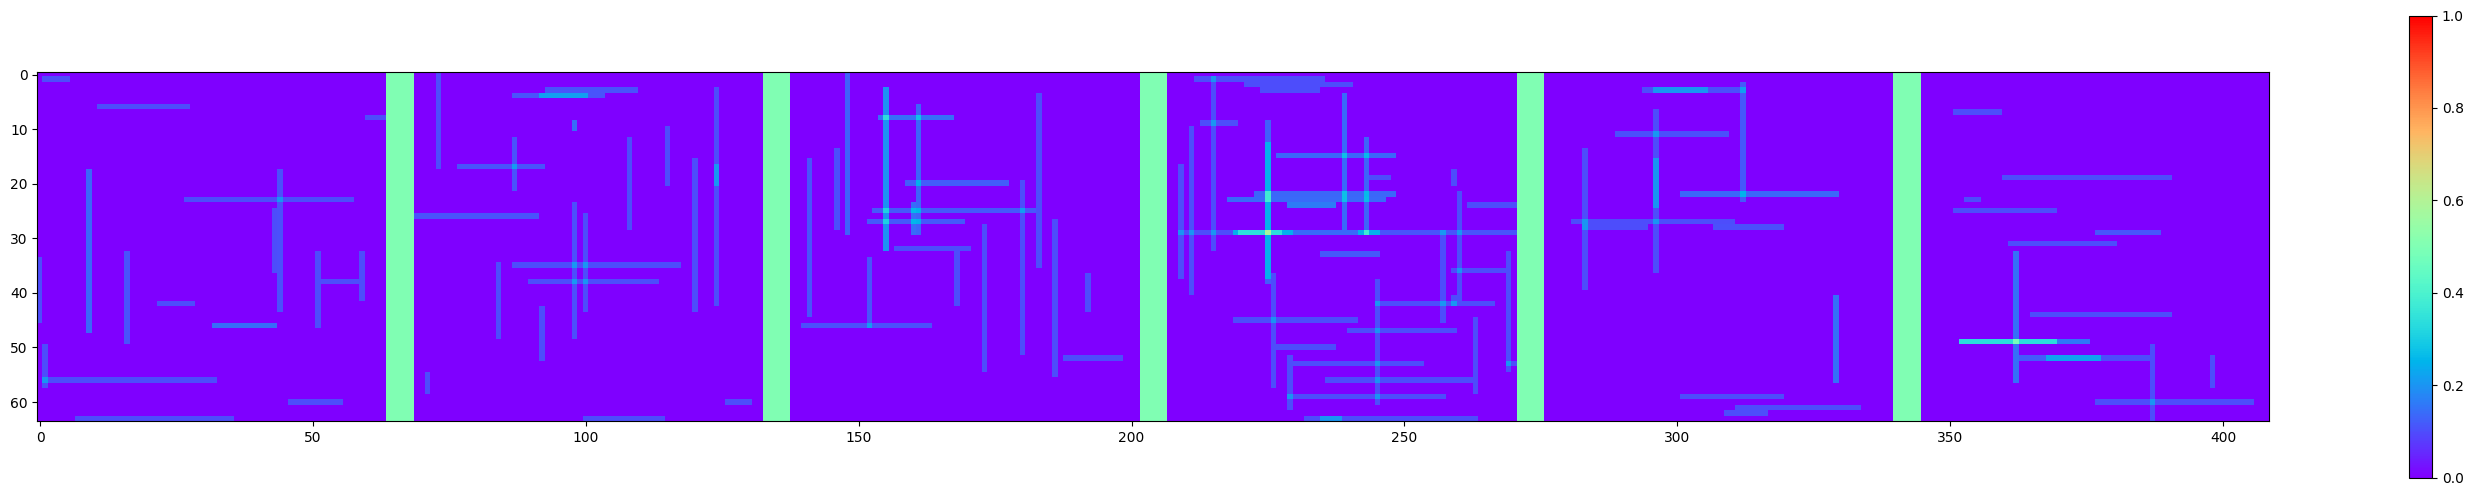

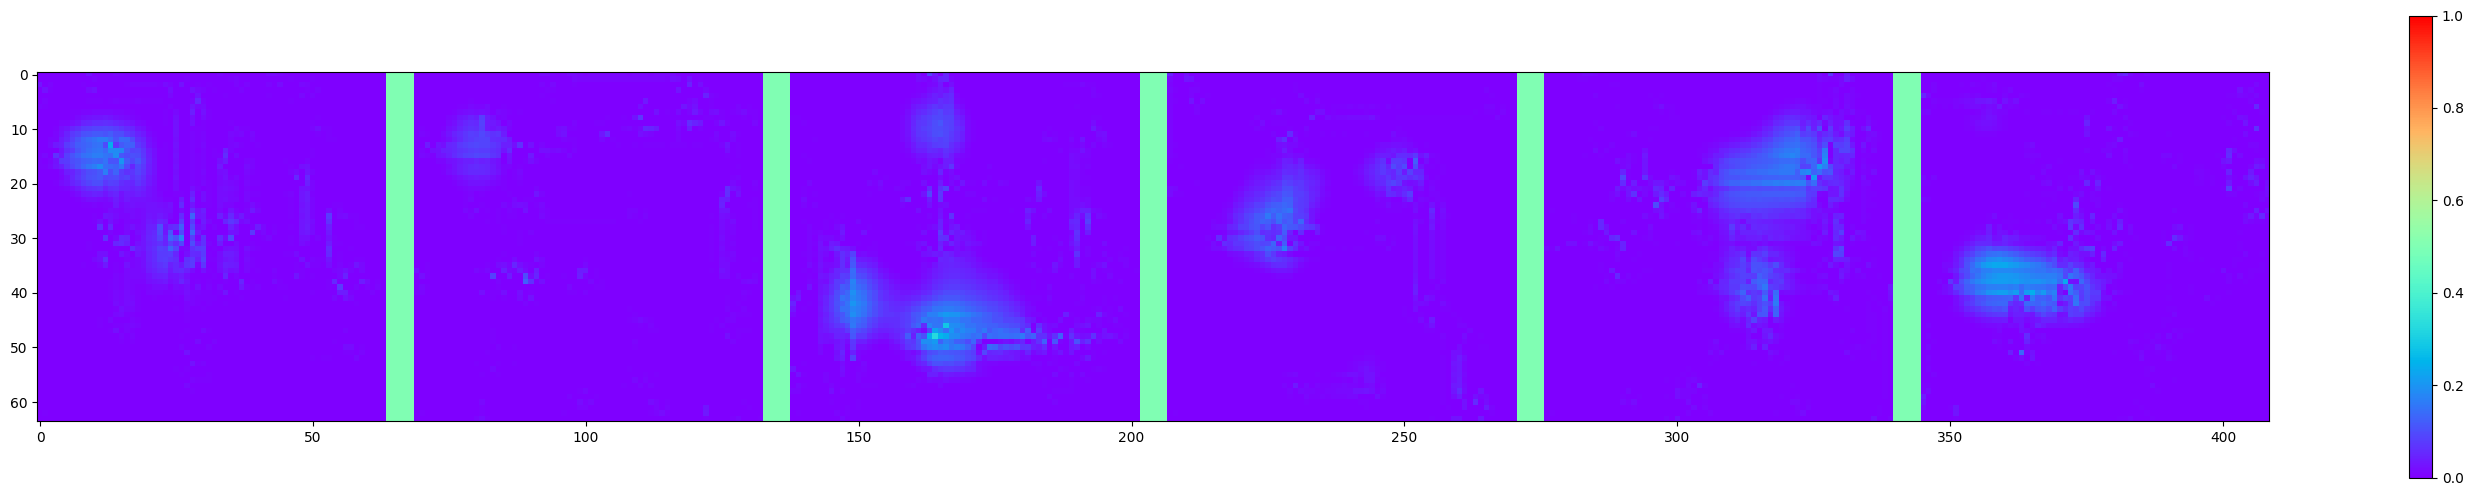

In [13]:
batch_size = 6
p = 0.5 / 100
target, _, input  = gen_image_with_integrated_signals(batch_size, p)


fig1 = plt.figure(1, figsize=(36, 6))
# champ T
voir_batch2D(full_target, 6, fig1, k=0, min_scale=0, max_scale=1)

# représentation des données d'opportunité par des segments
fig3 = plt.figure(3, figsize=(36, 6))
voir_batch2D(integrated_signals, 6, fig3, k=0, min_scale=0, max_scale=1)

fcn.eval()

input = input.cuda()

output = fcn(input)

output = output.cpu().detach()

fig4 = plt.figure(4, figsize = (36, 6))
voir_batch2D(output, 6, fig3, k=0, min_scale=0, max_scale=1)

**Exercice 2**

On souhaite montrer qu'un *fcn* peut utiliser simultanément les deux types de signaux (mesures ponctuelles et données d'opportunité).
Reprendre le code de **l'exercice 1** avec les deux champs en entrée. Comparer les performances aux plans quantitatif (courbes d'apprentissage) et qualitatif. Conclure.

In [22]:
ch_in = 2
ch_out = 1
size = 8

fcn = UNet(ch_in, ch_out, size).cuda()

optimizer = optim.Adam(fcn.parameters(), lr = 0.0002)

In [23]:
nepochs = 30
nbatches = 100
batchsize = 32

train_losses = []


for epoch in range(nepochs):


    print("Epoch " + str(epoch))
    epoch_losses  = []
    for i in range(nbatches):    # nbatch = datasetsize/batchsize
        #Load inputs

        optimizer.zero_grad()

        target, partial_input, input = gen_image_with_integrated_signals(batch_size, p)

        input = torch.cat((input, partial_input), dim = 1)

        target = target.cuda()
        input = input.cuda()

        output = fcn(input)

        loss = criterion(output, target)

        epoch_losses.append(loss.detach().cpu())

        loss.backward()

        optimizer.step()

        del target, input, loss
        torch.cuda.empty_cache()

    epoch_loss = np.mean(epoch_losses)
    train_losses.append(epoch_loss)

    print('epoch loss : \n')
    print(epoch_loss)

Epoch 0
epoch loss : 

0.08406166
Epoch 1
epoch loss : 

0.043966576
Epoch 2
epoch loss : 

0.038246933
Epoch 3
epoch loss : 

0.036649816
Epoch 4
epoch loss : 

0.034738176
Epoch 5
epoch loss : 

0.033354476
Epoch 6
epoch loss : 

0.034448553
Epoch 7
epoch loss : 

0.033981327
Epoch 8
epoch loss : 

0.0320092
Epoch 9
epoch loss : 

0.032204445
Epoch 10
epoch loss : 

0.03236544
Epoch 11
epoch loss : 

0.031613212
Epoch 12
epoch loss : 

0.032928377
Epoch 13
epoch loss : 

0.03235492
Epoch 14
epoch loss : 

0.03163821
Epoch 15
epoch loss : 

0.032190505
Epoch 16
epoch loss : 

0.032137442
Epoch 17
epoch loss : 

0.031384885
Epoch 18
epoch loss : 

0.03246986
Epoch 19
epoch loss : 

0.031838655
Epoch 20
epoch loss : 

0.032769922
Epoch 21
epoch loss : 

0.031628847
Epoch 22
epoch loss : 

0.032553308
Epoch 23
epoch loss : 

0.030014606
Epoch 24
epoch loss : 

0.031319268
Epoch 25
epoch loss : 

0.0315377
Epoch 26
epoch loss : 

0.03142884
Epoch 27
epoch loss : 

0.032092795
Epoch 28
epo

Text(0.5, 1.0, 'train losses')

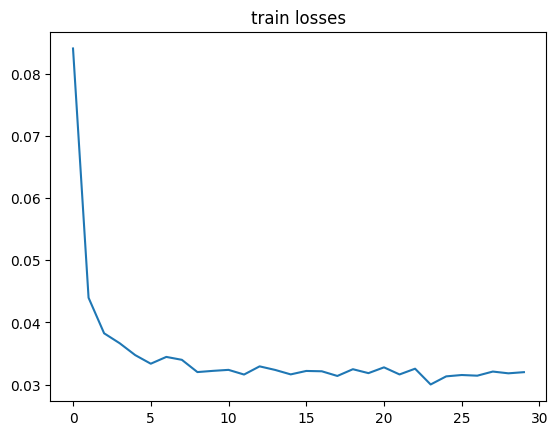

In [24]:
plt.plot(train_losses)
plt.title('train losses')

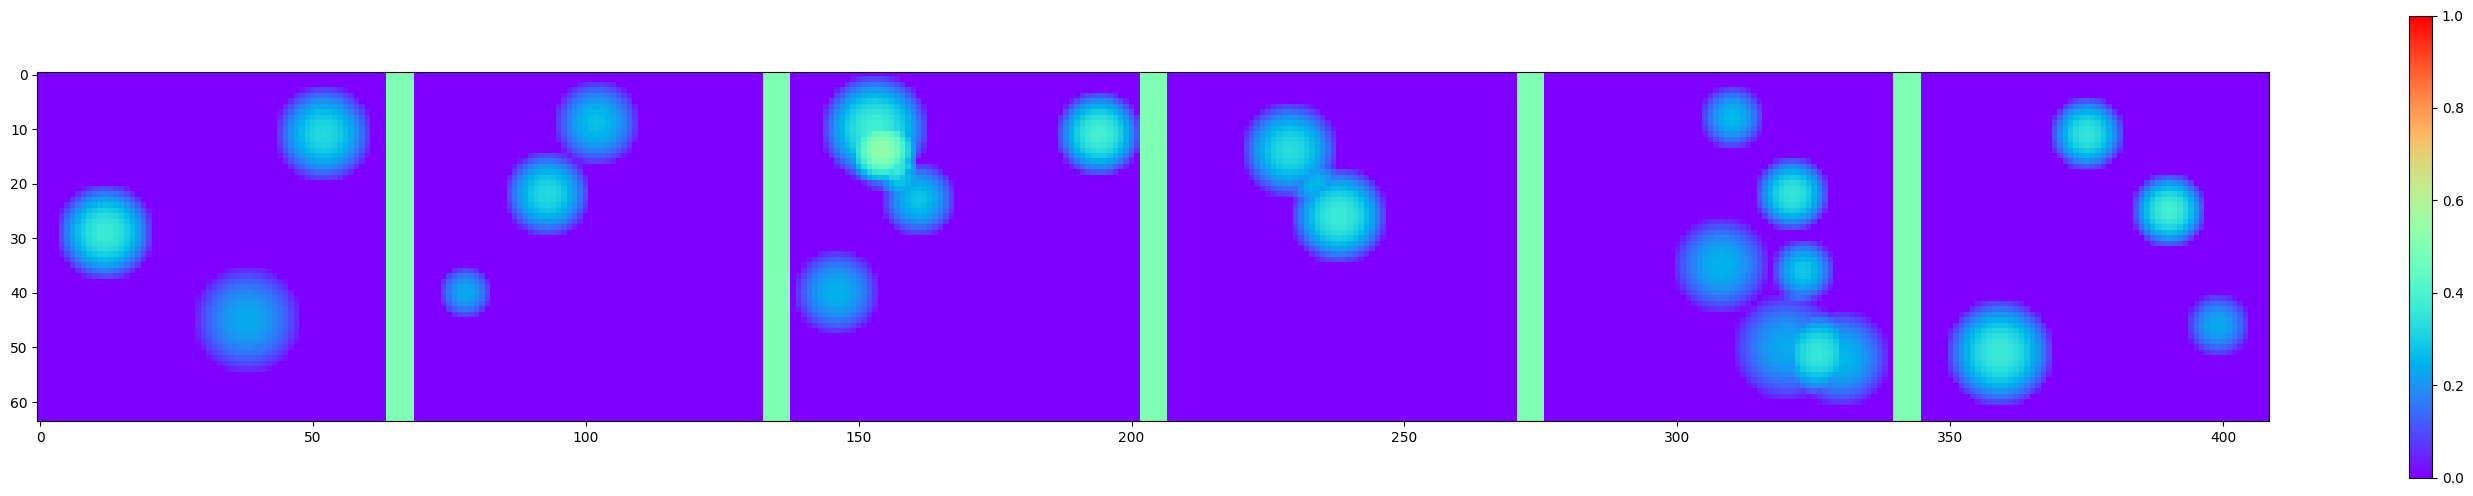

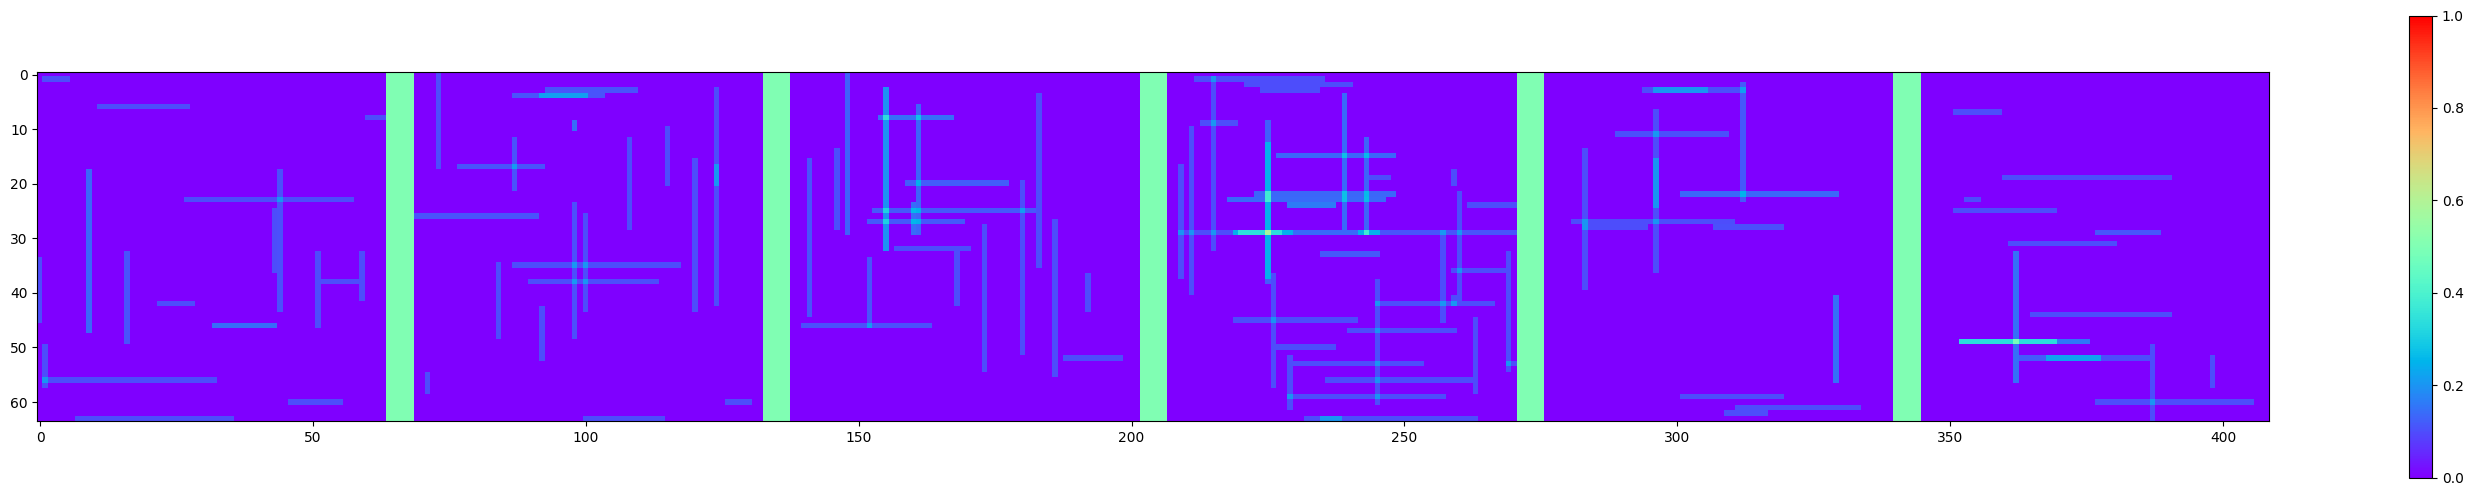

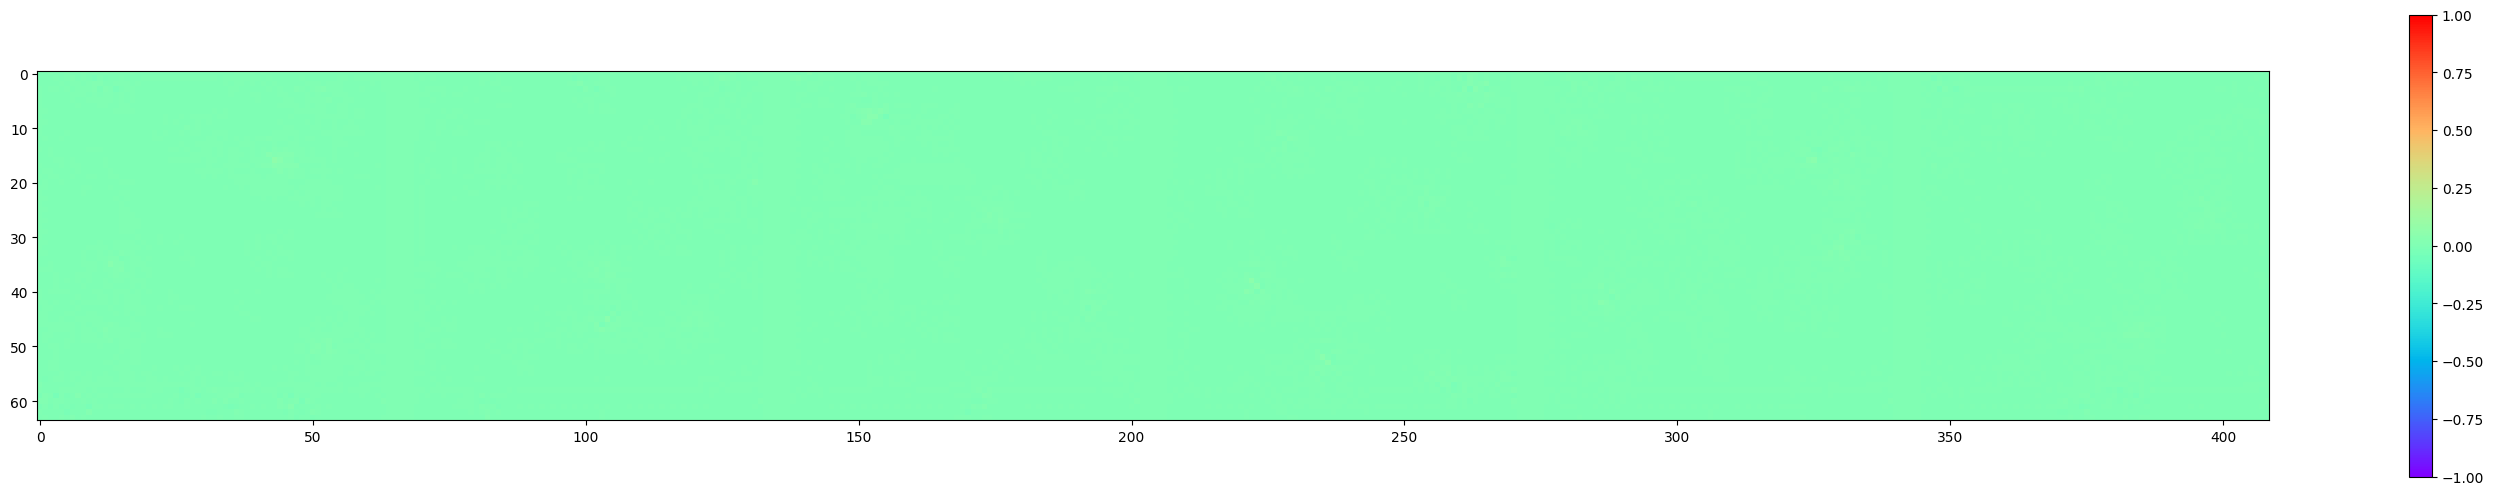

In [27]:
batch_size = 6
p = 0.5 / 100
target, partial_input, input  = gen_image_with_integrated_signals(batch_size, p)


fig1 = plt.figure(1, figsize=(36, 6))
# champ T
voir_batch2D(full_target, 6, fig1, k=0, min_scale=0, max_scale=1)

# représentation des données d'opportunité par des segments
fig3 = plt.figure(3, figsize=(36, 6))
voir_batch2D(integrated_signals, 6, fig3, k=0, min_scale=0, max_scale=1)

fcn.eval()

input = torch.cat((input, partial_input), dim = 1)

input = input.cuda()

output = fcn(input)

output = output.cpu().detach()

fig4 = plt.figure(4, figsize = (36, 6))
voir_batch2D(output, 6, fig3, k=0, min_scale=-1, max_scale=1)